## 1 Data Preprocessing

In [1]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from dtaidistance import dtw
from scipy.signal import correlate
import pmdarima as pm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
from time import sleep
import math

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
forex_data = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                              interval=Interval.in_15_minute, n_bars=4000)

sleep(1)

forex_data_lowertf = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                              interval=Interval.in_5_minute, n_bars=1000)


prices = forex_data['close']
print(prices)

# Save the original time index
original_time_index = prices.index

# Reset the index to 0 to 999
prices = prices.reset_index(drop=True)

datetime
2024-09-10 08:17:00    2502.97
2024-09-10 08:32:00    2503.61
2024-09-10 08:47:00    2504.83
2024-09-10 09:02:00    2506.55
2024-09-10 09:17:00    2505.34
                        ...   
2024-11-08 22:02:00    2686.71
2024-11-08 22:17:00    2688.04
2024-11-08 22:32:00    2687.74
2024-11-08 22:47:00    2686.00
2024-11-11 01:02:00    2682.95
Name: close, Length: 4000, dtype: float64


In [2]:
# Apply Savitzky-Golay filter to get the trend
# Note that in scipy Savitzky-Golay filter, the last elements are calculated by padding,
# so we would remove them to ensure an accurate trend data

sg_window_length = 19
sg_elements_removed = sg_window_length // 2   # 9 elements removed
yvalues = prices
yvalues_trend = savgol_filter(yvalues,19,1)
yvalues_trend = yvalues_trend[:(len(yvalues_trend)-sg_elements_removed)]   # Remove the extrapolated elements
# yvalues_seasonal = yvalues-yvalues_trend


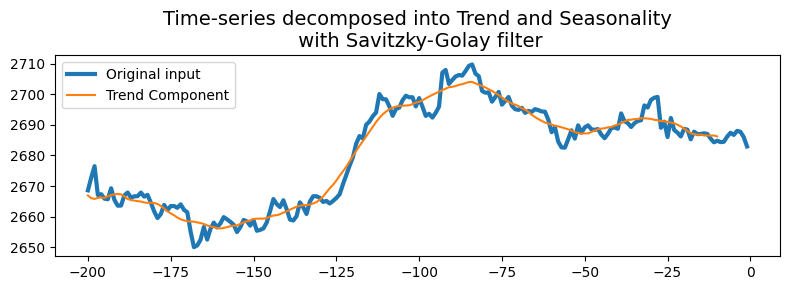

In [3]:
# Optional: Plot the decomposed time series
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-200,0), yvalues[-200:], label='Original input',linewidth=3)
#ax.plot(np.arange(-200,0), yvalues_trend[-200:], label='Trend Component')
ax.plot(np.arange(-200,-sg_elements_removed), yvalues_trend[-(200-sg_elements_removed):], label='Trend Component')
#ax.plot(yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()

## 2 Definition of Parameters and Functions

The min of trend_input_elements_list must be larger than the max of seasonal_input_elements_list, or else there would not be enough data to forecast.

Also the both the trend and seasonal forecast_storage_elements cannot be larger than the min of the input_elements_list, or else the length of the reconstructed signal would be differ.

In [4]:
# Definition of Forecast Parameters
forecast_elements = 40

trend_harmonics = 60
trend_validation_elements_list = np.arange(8, 24, 2)
trend_input_elements_list = np.arange(900, 1600, 4)
trend_gradient_factor_list = np.arange(-0.4, 0.41, 0.1)
trend_forecast_storage_elements = min(trend_input_elements_list)

seasonal_validation_elements = 8
seasonal_harmonics_list = np.arange(40, 70, 5)
seasonal_input_elements_list = np.arange(200, 800, 4)
seasonal_forecast_storage_elements = min(seasonal_input_elements_list)

visualization_elements_original = 40
visualization_elements_forecast = 24

In [5]:
# Function to perform FFT forecasting
def fft_forecast(signal, forecast_elements, target_harmonics=40, trend_factor=0):
    N = len(signal)
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(N)
    
    # Retain non-negative frequencies
    positive_freq_indices = fft_freq >= 0
    fft_freq_positive = fft_freq[positive_freq_indices]
    fft_result_positive = fft_result[positive_freq_indices]
    
    # Limit the number of harmonics
    num_harmonics = min(target_harmonics, len(fft_freq_positive))
    frequencies = fft_freq_positive[:num_harmonics]
    amplitudes = fft_result_positive[:num_harmonics]
    
    # Create extended indices including future points
    extended_indices = np.arange(N + forecast_elements)
    
    # Reconstruct the signal using the selected harmonics
    reconstructed_signal = np.zeros(N + forecast_elements)
    for i in range(num_harmonics):
        frequency = frequencies[i]
        amplitude_complex = amplitudes[i]
        amplitude = np.abs(amplitude_complex)
        phase = np.angle(amplitude_complex)
        omega = 2 * np.pi * frequency
        
        if frequency == 0:
            # DC component with added trend
            reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
        else:
            reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)
    
    # Add trend component for forecast portion
    if trend_factor != 0:
        trend = np.zeros_like(extended_indices, dtype=float)
        forecast_start = N
        for i in range(len(extended_indices)):
            if i >= forecast_start:
                trend[i] = trend_factor * (i - forecast_start + 1)
        reconstructed_signal += trend
        
    return reconstructed_signal


# Define error metric: Root Mean Squared Error (RMSE)
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))


def find_optimal_clusters(data, max_clusters=4):
    """Find optimal number of clusters using silhouette score."""
    # data is expected to be a 2D array of shape (n_samples, n_timepoints)
    n_samples = data.shape[0]
    data_reshaped = data.reshape(n_samples, -1)  # Ensure data is 2D
    
    # Try different numbers of clusters
    silhouette_scores = []
    for k in range(2, min(max_clusters + 1, n_samples)):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data_reshaped)
        score = silhouette_score(data_reshaped, cluster_labels)
        silhouette_scores.append(score)
    
    # Return optimal number of clusters
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
    return optimal_k


## 3 Trend Forecast

In [6]:
# Initialize a list to store results
results = []

# Generate trend forecasts by looping over different parameters
for trend_validation_elements in trend_validation_elements_list:
    for trend_input_elements in trend_input_elements_list:
        for trend_gradient_factor in trend_gradient_factor_list:

            # Calculate starting index, and get input data slice
            start_idx = len(yvalues_trend) - trend_validation_elements - trend_input_elements
            input_slice = yvalues_trend[start_idx:start_idx+trend_input_elements]

            # Generate forecast with FFT, with the trimmed sg_filter window length elements
            yvalues_trend_forecast = fft_forecast(
                input_slice,
                sg_elements_removed+trend_validation_elements+forecast_elements,
                trend_harmonics,
                trend_gradient_factor
            )
            
            # Convert forecasts to numpy arrays if they're pandas Series
            if isinstance(yvalues_trend_forecast, pd.Series):
                yvalues_trend_forecast = yvalues_trend_forecast.to_numpy()
            if isinstance(yvalues_trend, pd.Series):
                yvalues_trend = yvalues_trend.to_numpy()

            # Extract validation and test portions
            actual_validation = yvalues_trend[-trend_validation_elements:]
            forecast_validation = yvalues_trend_forecast[-trend_validation_elements-forecast_elements:-forecast_elements]

            # Calculate distances
            validation_distance = dtw.distance(actual_validation, forecast_validation)

            # Store the results
            results.append({
                'trend_validation_elements': trend_validation_elements,
                'trend_input_length': trend_input_elements,
                'trend_gradient_factor': trend_gradient_factor,
                'rmse_validation': calculate_rmse(actual_validation, forecast_validation),
                'dtw_validation': validation_distance
            })

# Choose the best parameters by first sorting by DTW distance and then RMSE
results_trend = pd.DataFrame(results)
results_trend = results_trend.sort_values(by='dtw_validation', ascending=True).head(20)
results_trend.sort_values(by='rmse_validation', ascending=True).head(10)

,trend_validation_elements,trend_input_length,trend_gradient_factor,rmse_validation,dtw_validation
2808,10,1448,-0.4,0.290934,0.512657
1279,8,1468,-0.3,0.345280,0.812746
1269,8,1464,-0.4,0.446798,0.986173
2845,10,1464,-0.3,0.491196,0.767179
4393,12,1452,-0.3,0.529746,0.933988
4402,12,1456,-0.3,0.549674,1.206471
1242,8,1452,-0.4,0.564077,1.219892
1260,8,1460,-0.4,0.587603,1.325447
1251,8,1456,-0.4,0.622275,1.432594
4411,12,1460,-0.3,0.656758,1.952537


In [7]:
# Placeholder for storing all trend forecasts
all_trend_forecasts = []

for _, row in results_trend.iterrows():
    trend_harmonics = 60
    # Convert parameters to integers, as they may have been read as float types
    trend_input_elements = int(row['trend_input_length'])
    trend_validation_elements = int(row['trend_validation_elements'])
    trend_gradient_factor = row['trend_gradient_factor']
    
    start_idx = len(yvalues_trend) - trend_validation_elements - trend_input_elements
    input_slice = yvalues_trend[start_idx:start_idx+trend_input_elements]
    
    # Generate trend forecast with FFT
    yvalues_trend_forecast = fft_forecast(
        input_slice,
        sg_elements_removed+trend_validation_elements + forecast_elements,
        trend_harmonics,
        trend_gradient_factor
    )
    
    # Store the forecast in all_trend_forecasts
    all_trend_forecasts.append(yvalues_trend_forecast[-trend_forecast_storage_elements-forecast_elements:])

# Calculate the mean forecast across all cases
mean_trend_forecast = np.mean(all_trend_forecasts, axis=0)

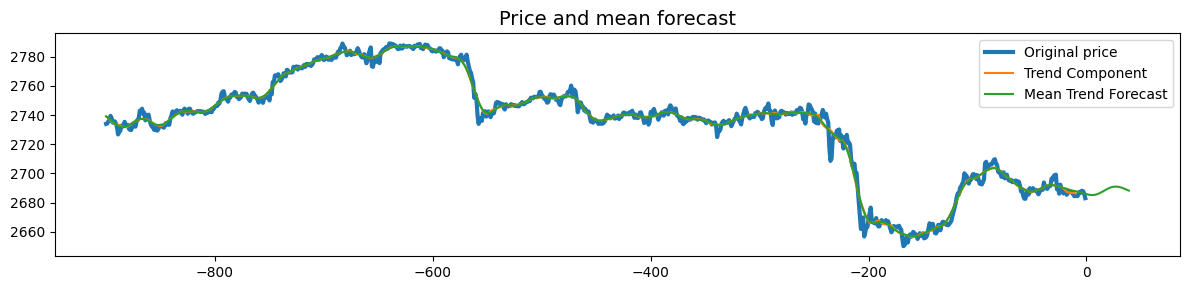

In [8]:
# Optional: Plot the mean_forecast
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(np.arange(-trend_forecast_storage_elements,0), yvalues[-trend_forecast_storage_elements:], label='Original price',linewidth=3)
ax.plot(np.arange(-trend_forecast_storage_elements,-sg_elements_removed), yvalues_trend[-(trend_forecast_storage_elements-sg_elements_removed):], label='Trend Component')
ax.plot(np.arange(-trend_forecast_storage_elements,forecast_elements), mean_trend_forecast[-(trend_forecast_storage_elements+forecast_elements):], label='Mean Trend Forecast')
#ax.plot(yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Price and mean forecast', fontsize=14)
plt.tight_layout()
plt.show()

## 4.1 Seasonal Forecast

In [9]:
# Calculate the seasonal component
yvalues_seasonal = yvalues[-trend_forecast_storage_elements:] - mean_trend_forecast[-(trend_forecast_storage_elements+forecast_elements):-forecast_elements]

# Initialize a list to store results
results = []

# Generate forecasts by looping over different parameters
for seasonal_harmonics in seasonal_harmonics_list:
    for seasonal_input_elements in seasonal_input_elements_list:
        # Calculate starting index, and get input data slice
        start_idx = len(yvalues_seasonal) - seasonal_validation_elements - seasonal_input_elements
        input_slice = yvalues_seasonal[start_idx:start_idx+seasonal_input_elements]

        # Generate forecast with FFT
        yvalues_seasonal_forecast = fft_forecast(
            input_slice,
            seasonal_validation_elements+forecast_elements,
            seasonal_harmonics
        )
        
        # Convert forecasts to numpy arrays if they're pandas Series
        if isinstance(yvalues_seasonal_forecast, pd.Series):
            yvalues_seasonal_forecast = yvalues_seasonal_forecast.to_numpy()
        if isinstance(yvalues_seasonal, pd.Series):
            yvalues_seasonal = yvalues_seasonal.to_numpy()

        # Extract validation and test portions
        actual_validation = yvalues_seasonal[-seasonal_validation_elements:]
        forecast_validation = yvalues_seasonal_forecast[-seasonal_validation_elements-forecast_elements:-forecast_elements]

        # Calculate distances
        validation_distance = dtw.distance(actual_validation, forecast_validation)

        # Store the results
        results.append({
            'seasonal_input_length': seasonal_input_elements,
            'seasonal_harmonics': seasonal_harmonics,
            'rmse_validation': calculate_rmse(actual_validation, forecast_validation),
            'dtw_validation': validation_distance
        })

results_seasonal = pd.DataFrame(results)
results_seasonal = results_seasonal.sort_values(by='dtw_validation', ascending=True).head(20)
#results_seasonal = results_seasonal.sort_values(by='rmse_validation', ascending=True).head(20)
results_seasonal

,seasonal_input_length,seasonal_harmonics,rmse_validation,dtw_validation
29,316,40,1.466535,2.135834
351,404,50,1.137708,2.160724
501,404,55,1.316211,2.412457
801,404,65,1.435822,2.415512
629,316,60,1.894320,2.460799
185,340,45,1.192753,2.470435
779,316,65,1.966287,2.504256
661,444,60,1.930062,2.552265
174,296,45,2.115142,2.704675
481,324,55,1.613495,2.705105


In [10]:
# Placeholder for storing all seasonal forecasts
all_seasonal_forecasts = []

for _, row in results_seasonal.iterrows():
    seasonal_input_elements = int(row['seasonal_input_length'])
    seasonal_harmonics = int(row['seasonal_harmonics'])
    
    start_idx = len(yvalues_seasonal) - seasonal_validation_elements - seasonal_input_elements
    input_slice = yvalues_seasonal[start_idx:start_idx + seasonal_input_elements]
    
    yvalues_seasonal_forecast = fft_forecast(
        input_slice,
        seasonal_validation_elements + forecast_elements,
        seasonal_harmonics
    )
    
    # Store the forecast in all_seasonal_forecasts
    all_seasonal_forecasts.append(yvalues_seasonal_forecast[-seasonal_forecast_storage_elements-forecast_elements:])


## 4.2 Clustering of Seaonsal Forecasts

In [11]:
# Convert to numpy arrays for easier manipulation
all_seasonal_forecasts = np.array(all_seasonal_forecasts)

# Get the validation and first equal amount of forecast data for clustering
end_idx = -forecast_elements + seasonal_validation_elements
start_idx = -forecast_elements - seasonal_validation_elements
clustering_data = all_seasonal_forecasts[:, start_idx:end_idx]
n_samples = clustering_data.shape[0]
data_reshaped = clustering_data.reshape(n_samples, -1)

# Find optimal number of clusters
n_clusters = find_optimal_clusters(clustering_data, 3)

# Perform clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(data_reshaped)

# Group forecasts by cluster
cluster_members = defaultdict(list)
for idx, label in enumerate(cluster_labels):
    cluster_members[label].append(idx)

# Calculate cluster means and intra-cluster distances
cluster_means = {}
intra_cluster_distances = {}
for label, indices in cluster_members.items():
    cluster_data = all_seasonal_forecasts[indices]
    cluster_means[label] = np.mean(cluster_data, axis=0)
    
    # Compute intra-cluster distance (mean pairwise distance within the cluster)
    distances = []
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            dist = np.linalg.norm(cluster_data[i] - cluster_data[j])
            distances.append(dist)
    if distances:
        intra_cluster_distance = np.mean(distances)
    else:
        intra_cluster_distance = 0  # Single member in cluster
    intra_cluster_distances[label] = intra_cluster_distance


## 5 TFO

In [12]:
# TFO Calculation Functions

def essf(series, period):
    """Ehlers' SuperSmoother Filter (ESSF)"""
    SQRT2xPI = np.sqrt(2.0) * np.pi
    alpha = SQRT2xPI / period
    beta = np.exp(-alpha)
    coef2 = -beta ** 2
    coef1 = 2.0 * beta * np.cos(alpha)
    coef0 = 1.0 - coef1 - coef2

    # Calculate sma2
    sma2 = (series + series.shift(1).fillna(series)) * 0.5

    # Initialize ESSF array
    ess = np.full(len(series), np.nan)
    ess[0] = sma2.iloc[0]

    for t in range(1, len(series)):
        sma2_t = sma2.iloc[t]
        ess_t1 = ess[t - 1]
        ess_t2 = ess[t - 2] if t - 2 >= 0 else 0.0

        ess[t] = coef0 * sma2_t + coef1 * ess_t1 + coef2 * ess_t2

    return pd.Series(ess, index=series.index)

def sum_diffs(series, period):
    """Sum of Differences"""
    E = np.zeros(len(series))
    for i in range(1, period + 1):
        shifted_series = series.shift(i).fillna(0)
        E += (series - shifted_series)
    E /= period
    return pd.Series(E, index=series.index)

def ema_recursive(series, period):
    """Exponential Moving Average (EMA) calculated recursively"""
    coef0 = 2.0 / (period + 1.0)
    coef1 = 1.0 - coef0
    EMA = np.full(len(series), np.nan)
    EMA[0] = series.iloc[0]

    for t in range(1, len(series)):
        series_t = series.iloc[t]
        EMA_t1 = EMA[t - 1]
        EMA[t] = coef0 * series_t + coef1 * EMA_t1

    return pd.Series(EMA, index=series.index)

def fRMS(series, period):
    """Fast Root Mean Square (fRMS)"""
    squared_series = series ** 2
    ema_squared = ema_recursive(squared_series, period)
    sqrt_ema = np.sqrt(ema_squared)
    result = np.nan_to_num(series / sqrt_ema, 0)
    return result

def trendflex(series, period_essf, period_tflx, period_frms):
    """Ehlers' TrendFlex Oscillator (TFO)"""
    essf_filtered = essf(series, period_essf)
    sum_diffs_filtered = sum_diffs(essf_filtered, period_tflx)
    tfo = fRMS(sum_diffs_filtered, period_frms)
    return tfo


# Parameters for Calculating TFO
periodTrendFlex = 20
useSuperSmootherOverride = False
periodSuperSmoother = 7.5
postSmooth = 33.0
if not useSuperSmootherOverride:
    periodSuperSmoother = periodTrendFlex * 0.5

# Calculate TFO
forex_data_lowertf['TFO'] = trendflex(forex_data_lowertf['close'], periodSuperSmoother, periodTrendFlex, postSmooth)

# Cut TFO data into suitable length (M15 to M5)
tfo_values = forex_data_lowertf['TFO'].iloc[-(visualization_elements_original)*3:]

## 6 Plotting

In [13]:
# Prepare common data slices and indices
len_original_slice = visualization_elements_original
forecast_slice_start_idx = -forecast_elements-visualization_elements_original
forecast_slice_end_idx   = -forecast_elements+visualization_elements_forecast
original_slice_idx_list = np.arange(-visualization_elements_original, 0)
forecast_slice_idx_list = np.arange(-visualization_elements_original, visualization_elements_forecast)

# Prepare the slices, which is originally in different lengths
prices_slice = prices[-visualization_elements_original:]
all_trend_forecasts_slice = np.array(all_trend_forecasts)[:, forecast_slice_start_idx:forecast_slice_end_idx]
mean_trend_forecasts_slice = mean_trend_forecast[forecast_slice_start_idx:forecast_slice_end_idx]
yvalues_seasonal_slice = yvalues_seasonal[-visualization_elements_original:]
all_seasonal_forecasts_slice = np.array(all_seasonal_forecasts)[:, forecast_slice_start_idx:forecast_slice_end_idx]
cluster_means_slice = {}
for label, data in cluster_means.items():
    cluster_means_slice[label] = np.array(data)[forecast_slice_start_idx:forecast_slice_end_idx]

# Get the last data time
last_datetime = forex_data.index[-1]

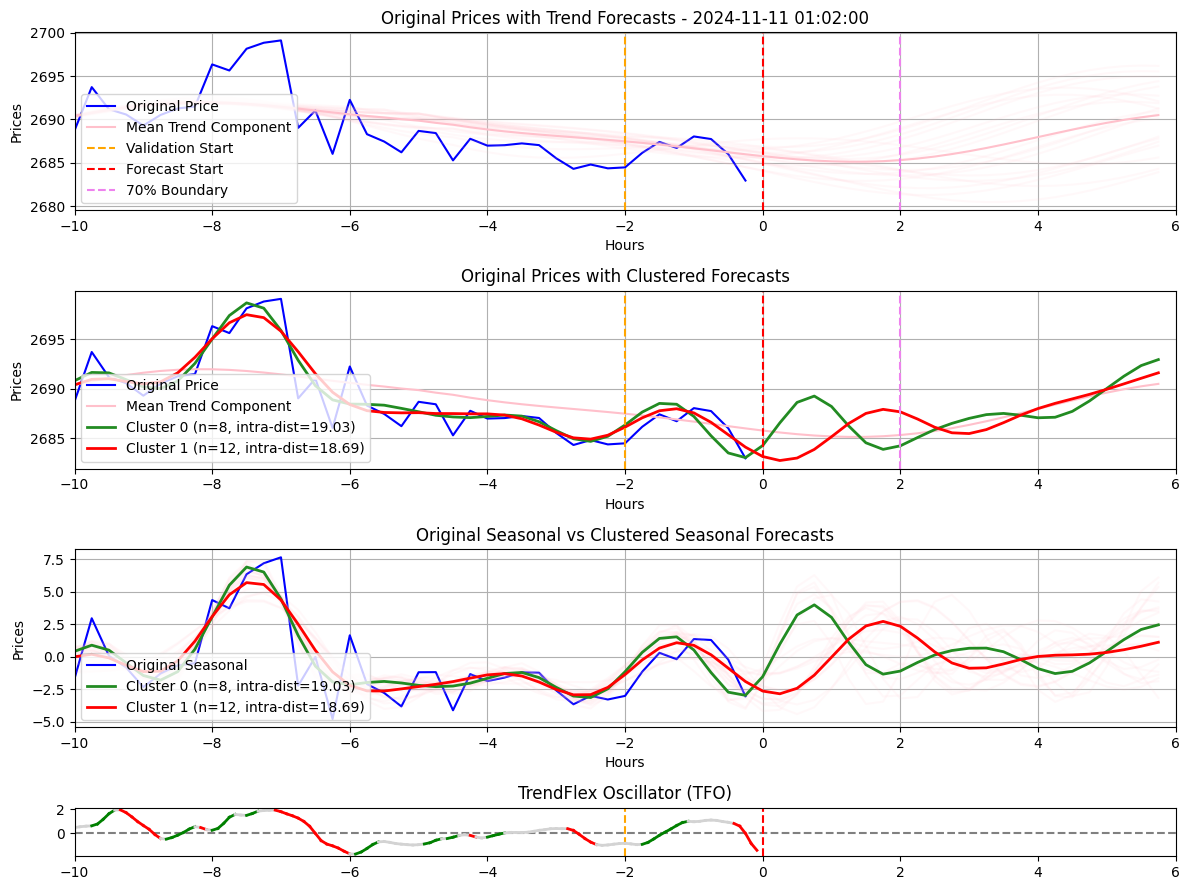

In [14]:
# Plotting
plt.figure(figsize=(12, 9))
colors = ['forestgreen', 'red', 'darkorange', 'dodgerblue']

# Plot 1: Original Price with Trend Forecasts
plt.subplot(7, 1, (1,2))
plt.plot(original_slice_idx_list / 4, prices_slice, label="Original Price", color='blue')
for row in all_trend_forecasts_slice:
    plt.plot(forecast_slice_idx_list / 4, row, color='pink', alpha=0.1)
plt.plot(forecast_slice_idx_list / 4, mean_trend_forecasts_slice, label='Mean Trend Component', color='pink')
plt.axvline(x=-seasonal_validation_elements / 4, color='orange', linestyle='--', label="Validation Start")
plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
plt.axvline(x=seasonal_validation_elements / 4, color='violet', linestyle='--', label="70% Boundary")
plt.legend(loc = "lower left")
plt.title(f"Original Prices with Trend Forecasts - {last_datetime}")
plt.xlim(-math.ceil((visualization_elements_original)/4), math.ceil(visualization_elements_forecast/4))
plt.xlabel("Hours")
plt.ylabel("Prices")
plt.grid(True)



# Plot 2: Original Price with Clustered Forecasts
plt.subplot(7, 1, (3,4))
plt.plot(original_slice_idx_list / 4, prices_slice, label="Original Price", color='blue')
plt.plot(forecast_slice_idx_list / 4, mean_trend_forecasts_slice, label='Mean Trend Component', color='pink')
for label, indices in cluster_members.items():
    plt.plot(
        forecast_slice_idx_list / 4,
        mean_trend_forecasts_slice+cluster_means_slice[label],
        color=colors[label],
        linewidth=2,
        label=f'Cluster {label} (n={len(indices)}, intra-dist={intra_cluster_distances[label]:.2f})'
    )
plt.axvline(x=-seasonal_validation_elements / 4, color='orange', linestyle='--')
plt.axvline(x=0, color='red', linestyle='--')
plt.axvline(x=seasonal_validation_elements / 4, color='violet', linestyle='--')
plt.legend(loc = "lower left")
plt.title(f"Original Prices with Clustered Forecasts")
plt.xlim(-math.ceil((visualization_elements_original)/4), math.ceil(visualization_elements_forecast/4))
plt.xlabel("Hours")
plt.ylabel("Prices")
plt.grid(True)

# Plot 3: Original Seasonal vs Clustered Seasonal Forecasts
plt.subplot(7, 1, (5,6))
plt.plot(original_slice_idx_list / 4, yvalues_seasonal_slice, label="Original Seasonal", color='blue')
for row in all_seasonal_forecasts_slice:
    plt.plot(forecast_slice_idx_list / 4, row, color='pink', alpha=0.1)
for label, indices in cluster_members.items():
    plt.plot(
        forecast_slice_idx_list / 4,
        cluster_means_slice[label],
        color=colors[label],
        linewidth=2,
        label=f'Cluster {label} (n={len(indices)}, intra-dist={intra_cluster_distances[label]:.2f})'
    )
plt.legend(loc = "lower left")
plt.title(f"Original Seasonal vs Clustered Seasonal Forecasts")
plt.xlim(-math.ceil((visualization_elements_original)/4), math.ceil(visualization_elements_forecast/4))
plt.xlabel("Hours")
plt.ylabel("Prices")
plt.grid(True)

# Plot 4: TFO
tfo_slope = tfo_values.diff()
plt.subplot(7, 1, 7)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(x=-seasonal_validation_elements / 4, color='orange', linestyle='--')
plt.axvline(x=0, color='red', linestyle='--')
for i in range(1, len(tfo_values)):
    tfoidx = [(i-len(tfo_values)-1)/12, (i-len(tfo_values))/12]
    if tfo_slope.iloc[i] >= 0.1:
        plt.plot(tfoidx, [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='green', linewidth=2)
    elif tfo_slope.iloc[i] <= -0.1:
        plt.plot(tfoidx, [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='red', linewidth=2)
    else:
        plt.plot(tfoidx, [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='lightgrey', linewidth=2)
plt.xlim(-math.ceil((visualization_elements_original)/4), math.ceil(visualization_elements_forecast/4))
plt.title('TrendFlex Oscillator (TFO)')

plt.tight_layout()
plt.show()
    